In [1]:
import os
import cv2
import time
import torch
import argparse
import numpy as np

from Detection.Utils import ResizePadding
from CameraLoader import CamLoader, CamLoader_Q
from DetectorLoader import TinyYOLOv3_onecls

from PoseEstimateLoader import SPPE_FastPose
from fn import draw_single

from Track.Tracker import Detection, Tracker
from ActionsEstLoader import TSSTG

from matplotlib import pyplot as plt

/home/johnson/anaconda3/envs/cuda11_6/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def kpt2bbox(kpt, ex=20):
    """Get bbox that hold on all of the keypoints (x,y)
    kpt: array of shape `(N, 2)`,
    ex: (int) expand bounding box,
    """
    return np.array((kpt[:, 0].min() - ex, kpt[:, 1].min() - ex,
                     kpt[:, 0].max() + ex, kpt[:, 1].max() + ex))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# DETECTION MODEL.
inp_dets = 384
detect_model = TinyYOLOv3_onecls(inp_dets, device=device)

# POSE MODEL.
inp_pose = ["224", "160"]
inp_pose = (int(inp_pose[0]), int(inp_pose[1]))
pose_model = SPPE_FastPose("resnet50", inp_pose[0], inp_pose[1], device=device)

# Tracker.
max_age = 30
tracker = Tracker(max_age=max_age, n_init=3)

# Actions Estimate.
action_model = TSSTG()
resize_fn = ResizePadding(inp_dets, inp_dets)

Loading pose model from ./Models/sppe/fast_res50_256x192.pth


In [42]:
f = 0 #160
result = 0 #138
count = 0 #144

# test yolo
for img in sorted(os.listdir("./Video/fall-01-cam0-rgb/")):
    f += 1
    frame = cv2.imread(f"./Video/fall-01-cam0-rgb/{img}")
    image = frame.copy()

    # Detect humans bbox in the frame with detector model.
    detected = detect_model.detect(frame, need_resize=True, expand_bb=10)

    # crop image with human bbox
    if detected is not None:
        result += 1
        for bbox in detected:
            croped = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            poses = pose_model.predict(croped, torch.tensor([[0, 0, croped.shape[1], croped.shape[0]]]), torch.tensor([[1]]))
            count += 1

In [31]:
def yolo_test(img):
    # Detect humans bbox in the frame with detector model.
    detected = detect_model.detect(img, need_resize=True, expand_bb=10)

    # crop image with human bbox
    if detected is not None:
        for bbox in detected:
            croped = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            return croped
        
    return None

def pose_test(img):
    poses = pose_model.predict(img, torch.tensor([[0, 0, img.shape[1], img.shape[0]]]), torch.tensor([[1]]))
    if poses:
        return poses
    return None

yolo_count = 0 #138
pose_count = 0 #136
for img in sorted(os.listdir("./Video/fall-01-cam0-rgb/")):
    frame = cv2.imread(f"./Video/fall-01-cam0-rgb/{img}")
    result = yolo_test(frame)

    if result is not None:
        yolo_count += 1
        pose = pose_test(result)
        if pose:
            pose_count += 1


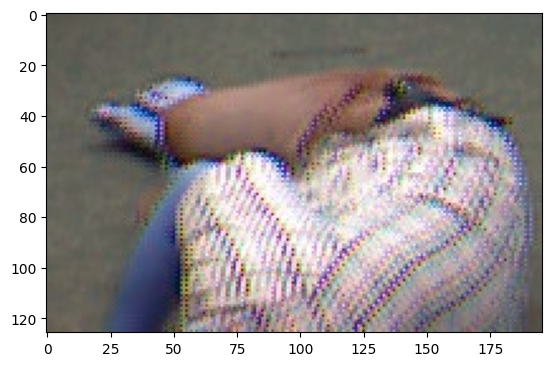

In [11]:
frame = cv2.imread(f"./Video/fall-01-cam0-rgb/fall-01-cam0-rgb-155.png")
detected = yolo_test(frame)
if detected is not None:
    plt.imshow(detected)

In [4]:
show_detected = False
show_skeleton = True
fps_time = 0
f = 0

outvid = False
save_out = "./result.mp4"
if save_out != '':
    outvid = True
    codec = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(save_out, codec, 30, (1280, 960))

img_list = [f"./Video/fall-01-cam0-rgb/fall-01-cam0-rgb-00{i}.png" for i in range(1,10)]

for img in sorted(os.listdir("./Video/fall-01-cam0-rgb/")):
    f += 1
    frame = cv2.imread(f"./Video/fall-01-cam0-rgb/{img}")
    image = frame.copy()
    
    # Detect humans bbox in the frame with detector model.
    detected = detect_model.detect(frame, need_resize=True, expand_bb=10)

    # Predict each tracks bbox of current frame from previous frames information with Kalman filter.
    tracker.predict()
    # Merge two source of predicted bbox together.
    for track in tracker.tracks:
        det = torch.tensor([track.to_tlbr().tolist() + [0.5, 1.0, 0.0]], dtype=torch.float32)
        detected = torch.cat([detected, det], dim=0) if detected is not None else det

    detections = []  # List of Detections object for tracking.
    if detected is not None:
        #detected = non_max_suppression(detected[None, :], 0.45, 0.2)[0]
        # Predict skeleton pose of each bboxs.
        poses = pose_model.predict(frame, detected[:, 0:4], detected[:, 4])

        # Create Detections object.
        detections = [Detection(kpt2bbox(ps['keypoints'].numpy()),
                                np.concatenate((ps['keypoints'].numpy(),
                                                ps['kp_score'].numpy()), axis=1),
                                ps['kp_score'].mean().numpy()) for ps in poses]

        # VISUALIZE.
        if show_detected:
            for bb in detected[:, 0:5]:
                frame = cv2.rectangle(frame, (int(bb[0]), int(bb[1])), (int(bb[2]), int(bb[3])), (0, 0, 255), 1)

        # Update tracks by matching each track information of current and previous frame or
        # create a new track if no matched.
        tracker.update(detections)

        # Predict Actions of each track.
        for i, track in enumerate(tracker.tracks):
            if not track.is_confirmed():
                continue

            track_id = track.track_id
            bbox = track.to_tlbr().astype(int)
            center = track.get_center().astype(int)

            action = 'pending..'
            clr = (0, 255, 0)
            # Use 30 frames time-steps to prediction.
            if len(track.keypoints_list) == 30:
                pts = np.array(track.keypoints_list, dtype=np.float32)
                out = action_model.predict(pts, frame.shape[:2])
                action_name = action_model.class_names[out[0].argmax()]
                action = '{}: {:.2f}%'.format(action_name, out[0].max() * 100)
                if action_name == 'Fall Down':
                    clr = (255, 0, 0)
                elif action_name == 'Lying Down':
                    clr = (255, 200, 0)

            # VISUALIZE.
            if track.time_since_update == 0:
                if show_skeleton:
                    frame = draw_single(frame, track.keypoints_list[-1])
                frame = cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 1)
                frame = cv2.putText(frame, str(track_id), (center[0], center[1]), cv2.FONT_HERSHEY_COMPLEX,
                                    0.4, (255, 0, 0), 2)
                frame = cv2.putText(frame, action, (bbox[0] + 5, bbox[1] + 15), cv2.FONT_HERSHEY_COMPLEX,
                                    0.4, clr, 1)
                
        # Show Frame.
        frame = cv2.resize(frame, (0, 0), fx=2., fy=2.)
        frame = cv2.putText(frame, '%d, FPS: %f' % (f, 1.0 / (time.time() - fps_time)),
                            (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        frame = frame[:, :, ::-1]

        if outvid:
            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            writer.write(img_rgb)

if outvid:
    writer.release()

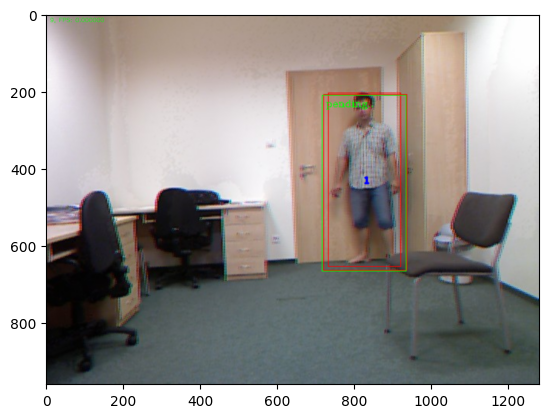

In [18]:
plt.imshow(frame)

In [14]:
outvid = False
save_out = "./result.mp4"
if save_out != '':
    outvid = True
    codec = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(save_out, codec, 30, (640, 480))

for i in sorted(os.listdir("./Video/fall-01-cam0-rgb/")):
    img = cv2.imread(f"./Video/fall-01-cam0-rgb/{i}")
    writer.write(img)
writer.release()

In [5]:
# UPDRS leg agility

'''
    {0,  "Nose"},
    {1,  "LEye"}, ignored
    {2,  "REye"}, ignored
    {3,  "LEar"}, ignored
    {4,  "REar"}, ignored
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},
'''

def yolo_test(img):
    # Detect humans bbox in the frame with detector model.
    detected = detect_model.detect(img, need_resize=True, expand_bb=10)

    # crop image with human bbox
    if detected is not None:
        for bbox in detected:
            croped = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
            return croped
        
    return None

def pose_test(img):
    poses = pose_model.predict(img, torch.tensor([[0, 0, img.shape[1], img.shape[0]]]), torch.tensor([[1]]))
    if poses:
        return poses
    return None

# Read video with OpenCV.
cap=cv2.VideoCapture('./Video/WholeBody2_right.mp4')

## Get video info
RES=(round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
fps = round(cap.get(cv2.CAP_PROP_FPS))

imgs = []

while(cap.isOpened()):
    ret, frame = cap.read()

    if ret:
        imgs.append(frame)
    
    else:
        break

cap.release()

lankles = [] # pose[0]["keypoints"][-2]
rankles = [] # pose[0]["keypoints"][-1]
for img in imgs:
    croped = yolo_test(img)
    if croped is not None:
        pose = pose_test(croped)
        if pose:
            rankles.append(pose[0]["keypoints"][-1][1].numpy())
            rankles.append(pose[0]["keypoints"][-1][1].numpy())

In [13]:
a = np.concatenate(rankles, axis=None)
temp = a.tobytes()
data = np.frombuffer(temp, dtype=np.float32)

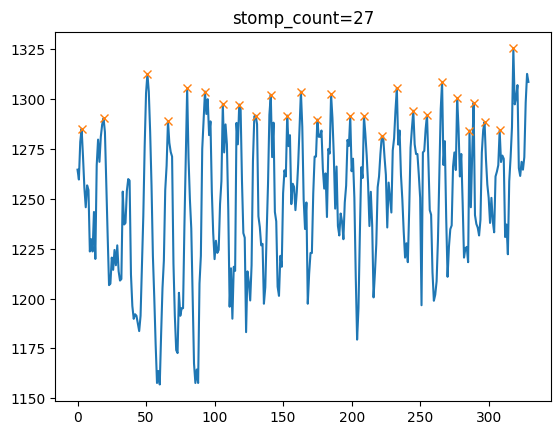

In [14]:
from scipy import signal
import io

copy = data.copy()
peaks, _ = signal.find_peaks(copy, height=1270, prominence=20)
plt.title(f"stomp_count={len(peaks)}")
plt.plot(copy)
plt.plot(peaks,np.array(copy)[peaks],"x")
buf = io.BytesIO()
plt.savefig(buf, format="png")